In [1]:
import pandas as pd
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from konlpy.tag import Mecab
import nltk
from collections import Counter
import itertools
import networkx as nx
import operator
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

In [2]:
with open('./data/recruit_df_0615.pkl', 'rb') as f:
    df = pickle.load(f)

#### Tokenizing

In [3]:
pos = ['NNG', 'NNP', 'NNB', 'SL']
m = Mecab('C:\Windows\mecab\mecab-ko-dic')
def tokenizer(text):
    tokens = m.pos(text)
    return [word for word, pos in filter(lambda x: (x[1] in pos), tokens)]

In [4]:
df['TOKENS'] = df['내용'].apply(tokenizer)
df.head()

,등록일,회사명,제목,내용,TOKENS
0,2023-06-14 18:04:02,한양증권,[한양증권] T&S부(결제업무부) 경력직원 채용 상세보기|채용안내 | 금융투자협회,[한양증권] T&S부(결제업무부) 경력직원 채용1. 모집부문1) 근무부서 : T&S...,"[한양증권, T, S, 부, 결제, 업무, 부, 경력, 직원, 채용, 모집, 부문,..."
1,2023-06-14 17:53:28,한양증권,[한양증권] 재무회계부 경력직원 채용 상세보기|채용안내 | 금융투자협회,[한양증권] 재무회계부 경력직원 채용1. 모집부문1) 근무부서 : 재무회계부2) 주...,"[한양증권, 재무, 회계부, 경력, 직원, 채용, 모집, 부문, 근무, 부서, 재무..."
2,2023-06-14 17:50:43,한국포스증권,[한국포스증권(주)] 리스크 관리 담당 채용공고(~07.09.) 상세보기|채용안내 ...,Ⅰ. 회사소개 - 2013년 국내 40여개 자산운용사와 증권 유관 기관들이 공동...,"[회사, 소개, 국내, 자산운용사, 증권, 유관, 기관, 공동, 출자, 설립, 펀드..."
3,2023-06-14 17:49:35,한양증권,[한양증권] AI운용부문(주식운용) 업무직 채용 상세보기|채용안내 | 금융투자협회,[한양증권] AI운용부문(주식운용) 업무직 채용1. 모집부문1) 근무부서 : AI운...,"[한양증권, AI, 운용, 부문, 주식, 운용, 업무, 직, 채용, 모집, 부문, ..."
4,2023-06-14 17:15:13,신한자산신탁,"[신한자산신탁] 경력직원 수시채용 (사내변호사, 신탁회계) 상세보기|채용안내 | 금...",신한자산신탁에서 꿈을 펼칠 열정 넘치는 직원들을 모집합니다.□ 모집분야 및 지원자격...,"[신한자산신탁, 꿈, 열정, 직원, 모집, 모집, 분야, 지원, 자격, 사내변호사,..."


#### Stopwords

In [5]:
def stopwords(tokens):
    stopwords = pd.read_csv('./data/stopwords.csv', encoding='utf-8-sig')
    stoplist = []
    for word in stopwords.word:
        stoplist.append(word)
    return list(set(tokens)-set(stoplist))

In [6]:
df['TOKENS_SW'] = df['TOKENS'].apply(stopwords)
df.head()

,등록일,회사명,제목,내용,TOKENS,TOKENS_SW
0,2023-06-14 18:04:02,한양증권,[한양증권] T&S부(결제업무부) 경력직원 채용 상세보기|채용안내 | 금융투자협회,[한양증권] T&S부(결제업무부) 경력직원 채용1. 모집부문1) 근무부서 : T&S...,"[한양증권, T, S, 부, 결제, 업무, 부, 경력, 직원, 채용, 모집, 부문,...","[채권, 증권, 거래, hygood, CEO, 실무, 규정, 과장, ghk, 경력자..."
1,2023-06-14 17:53:28,한양증권,[한양증권] 재무회계부 경력직원 채용 상세보기|채용안내 | 금융투자협회,[한양증권] 재무회계부 경력직원 채용1. 모집부문1) 근무부서 : 재무회계부2) 주...,"[한양증권, 재무, 회계부, 경력, 직원, 채용, 모집, 부문, 근무, 부서, 재무...","[재무회계, wssong, 거래, hygood, 세무, CEO, 실무, 규정, 수검..."
2,2023-06-14 17:50:43,한국포스증권,[한국포스증권(주)] 리스크 관리 담당 채용공고(~07.09.) 상세보기|채용안내 ...,Ⅰ. 회사소개 - 2013년 국내 40여개 자산운용사와 증권 유관 기관들이 공동...,"[회사, 소개, 국내, 자산운용사, 증권, 유관, 기관, 공동, 출자, 설립, 펀드...","[감시, 감독원, 보고서, 설립, 입력, 공동, ETF, 증권, 담보, 국내, 유관..."
3,2023-06-14 17:49:35,한양증권,[한양증권] AI운용부문(주식운용) 업무직 채용 상세보기|채용안내 | 금융투자협회,[한양증권] AI운용부문(주식운용) 업무직 채용1. 모집부문1) 근무부서 : AI운...,"[한양증권, AI, 운용, 부문, 주식, 운용, 업무, 직, 채용, 모집, 부문, ...","[거래, hygood, CEO, 실무, 규정, 운용, aram, 경력자, 관리, 경..."
4,2023-06-14 17:15:13,신한자산신탁,"[신한자산신탁] 경력직원 수시채용 (사내변호사, 신탁회계) 상세보기|채용안내 | 금...",신한자산신탁에서 꿈을 펼칠 열정 넘치는 직원들을 모집합니다.□ 모집분야 및 지원자격...,"[신한자산신탁, 꿈, 열정, 직원, 모집, 모집, 분야, 지원, 자격, 사내변호사,...","[법률, 법, 증명서, 자격증, 소송, 변호사, 복지, 사업, 유관, 부동산, 세무..."


#### 단어별 count

In [7]:
df['TOKENS_FOR_CNT'] = df.TOKENS_SW.apply(', '.join)
token_list = []
for idx, row in df.iterrows():
    tokens = row['TOKENS_FOR_CNT'].split(', ')
    for item in tokens:
        token_list.append(item)
        
counts = Counter(token_list)
freq = pd.DataFrame.from_dict(counts, orient="index").reset_index()
freq = freq.rename(columns={'index':'word', 0: 'cnt'})
freq = freq.sort_values(by='cnt', ascending=False)
freq.head()

,word,cnt
12,경력,531
77,투자,423
11,관리,367
104,자격증,355
57,운용,353


In [8]:
freq.to_csv('C:/Users/Administrator/Desktop/freq_0615.csv', index=False, encoding='utf-8-sig')

In [14]:
freq_top10 = freq.head(10).word.to_list()
freq_cnt_95q = freq[freq['cnt']>=freq.cnt.quantile(q=0.95)].word.to_list()

#### 일자별 단어 출현 횟수

In [19]:
df.loc[:,['등록일']] = df.loc[:, ['등록일']].astype('str')
df['등록월'] = df['등록일'].str.slice(1, 8)
df_ts = df[['등록월', 'TOKENS_SW']]
df_ts = df_ts.groupby('등록월').agg(lambda x: nltk.FreqDist([w for wordlist in x for w in wordlist]))
df_ts

,TOKENS_SW
등록월,
2023-04,"{'자격증': 134, '담보': 5, '증빙': 49, '인턴': 26, '상환'..."
2023-05,"{'산출': 9, '영등포구': 26, '기사': 6, '대학': 25, 'OCBC..."
2023-06,"{'채권': 17, '증권': 25, '거래': 23, 'hygood': 6, 'C..."


In [21]:
temp = df_ts.pop('TOKENS_SW').apply(pd.Series).stack().explode()
temp_add = pd.DataFrame({'word':temp.index.get_level_values(1),
                        'count':temp.values},
                       index = temp.index.get_level_values(0))
freq_month = df_ts.join(temp_add, how='right')
freq_month = freq_month.sort_values(['등록월','count'], ascending=[True, False])

freq_month_top10 = freq_month[freq_month['word'].isin(freq_top10)].reset_index()
freq_month_top10.등록월 = freq_month_top10.등록월.apply('="{}-01"'.format)
freq_month_top10.to_csv('C:/Users/Administrator/Desktop/freq_month_top10_0615.csv', index=False, encoding='utf-8-sig')

#### 단어 간 동시 출현 빈도

In [57]:
# TOP10 단어가 포함되어 있는 데이터만 선택
df_bigram = df[df.TOKENS_SW.apply(lambda x: any([f in x for f in freq_top10]))]
t=[]
df_bigram['TOKENS_SW'].apply(lambda x: t.append(x))
len(t)

777

In [59]:
# 95% quantile 값 이상 출현한 단어만 선택
for token_list in t:
    for token in token_list:
        if token not in freq_cnt_95q:
            token_list.remove(token)

In [61]:
unq = set(itertools.chain(*t))
print(len(unq))

1751


In [62]:
# 시간 엄청 많이 걸리니까 sklearn CountVectorizer() 사용 고려
t_cnt = {x: sum(1 for n in t if all(i in n for i in x))  for x in itertools.combinations(unq, 2)}
df_cnt = pd.DataFrame.from_dict(t_cnt, orient='index')
df_cnt.head()

,0
"(trustonasset, 생각)",0
"(trustonasset, 별)",0
"(trustonasset, Operating)",0
"(trustonasset, 반영)",0
"(trustonasset, 상단)",0


In [63]:
temp=[]
for i in range(len(df_cnt)):
    temp.append([df_cnt.index[i][0],df_cnt.index[i][1],df_cnt[0][i]])
    
df_cnt=pd.DataFrame(temp, columns=["token1","token2","co_freq"])
df_cnt.head()

,token1,token2,co_freq
0,trustonasset,생각,0
1,trustonasset,별,0
2,trustonasset,Operating,0
3,trustonasset,반영,0
4,trustonasset,상단,0


In [64]:
df_cnt = df_cnt[df_cnt['co_freq']>0]
df_cnt = df_cnt.sort_values('co_freq', ascending=False)
df_cnt.shape

(64032, 3)

In [65]:
with open('./data/df_cnt.pkl', 'wb') as f:
    pickle.dump(df_cnt, f)

In [66]:
df_cnt.to_csv('./data/단어간 연관도_0421.csv', index=False, encoding='utf-8-sig')

#### networkx 시각화

In [3]:
with open('./data/df_cnt.pkl', 'rb') as f:
    df_cnt = pickle.load(f)

In [67]:
df_cnt_nx = df_cnt.head(50).reset_index()
df_cnt_nx.head()

,index,token1,token2,co_freq
0,285379,투자,경력,221
1,1114066,경력,관리,206
2,904570,자격증,경력,193
3,399450,보유자,경력,167
4,1114684,경력,운용,155


In [68]:
G_centrality = nx.Graph()

for idx in range(len(df_cnt_nx)):
    G_centrality.add_edge(df_cnt_nx['token1'][idx], df_cnt_nx['token2'][idx], weight=df_cnt_nx['co_freq'][idx])
    
dgr = nx.degree_centrality(G_centrality)        # 연결 중심성 - 연결된 node가 많을수록 node의 크기가 커짐
pgr = nx.pagerank(G_centrality)                 # 페이지 랭크

sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

In [69]:
G= nx.Graph()

for i in range(len(sorted_pgr)):
    G.add_node(sorted_pgr[i][0], nodesize=sorted_dgr[i][1])
    
for idx in range(len(df_cnt_nx)):
    G.add_weighted_edges_from([(df_cnt_nx['token1'][idx], df_cnt_nx['token2'][idx], df_cnt_nx['co_freq'][idx])])
    
sizes = [G.nodes[node]['nodesize']*500 for node in G]
options = {
    'edge_color': '#A2BFFF',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
    'node_color': '#FAE1AC'
}

font_name = fm.FontProperties(fname='./malgun.ttf').get_name()
rc('font', family=font_name)

In [74]:
print(G.edges)

[('경력', '투자'), ('경력', '관리'), ('경력', '자격증'), ('경력', '보유자'), ('경력', '운용'), ('경력', '자산운용사'), ('경력', '계약직'), ('경력', '펀드'), ('경력', '경력자'), ('경력', '인재'), ('경력', '회계'), ('경력', '증명서'), ('경력', '개발'), ('경력', '대리'), ('경력', '부동산'), ('경력', '전문'), ('경력', '분석'), ('경력', '자산운용'), ('경력', '경영'), ('경력', '과장'), ('경력', '소지자'), ('경력', '마케팅'), ('경력', '상품'), ('경력', '국내'), ('경력', '정규직'), ('경력', '실무'), ('경력', '영어'), ('경력', '해외'), ('경력', '경험'), ('경력', '신탁'), ('경력', '증권사'), ('경력', '급여'), ('경력', '서울'), ('경력', '경력직'), ('투자', '관리'), ('투자', '보유자'), ('투자', '자산운용사'), ('투자', '운용'), ('투자', '회계'), ('투자', '펀드'), ('투자', '인재'), ('관리', '보유자'), ('관리', '자격증'), ('관리', '계약직'), ('관리', '회계'), ('자격증', '보유자'), ('자격증', '계약직'), ('자격증', '경력자'), ('자격증', '증명서'), ('운용', '자산운용사')]


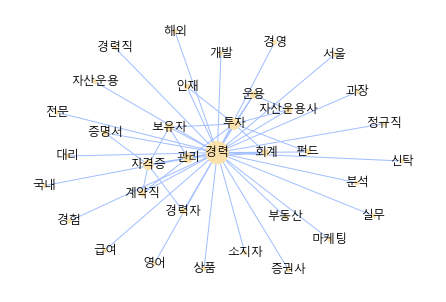

In [73]:
nx.draw(G, node_size=sizes, pos=nx.spring_layout(G, k=5, iterations=100), **options, font_family=font_name)
ax = plt.gca()
# ax.collections[0].set_edgecolor("#555555")
plt.show()